In [1]:
import yfinance as yf 
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout 
from keras.optimizers import Adam
from math import sqrt

In [2]:
#Defining the list of stock tickers
tickers = ["AMZN", "AAPL", "MSFT", "META", "GOOGL"]

#Definng the start and end dates
start_date = dt.datetime.now() - dt.timedelta(days = 6*365)
end_date = dt.datetime.now()

#Here we will fetch the data from yfinance and store it in a dictionary

stock_data = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    stock_data[ticker] = stock.history(start = start_date, end = end_date).dropna()

#Concatenate the stock data obtained into one dataframe
data = pd.concat(stock_data.values(), axis =1, keys= stock_data.keys())

data.index = pd.to_datetime(data.index)
print(data.head())
data.describe()

                                AMZN                                   \
                                Open       High        Low      Close   
Date                                                                    
2017-04-03 00:00:00-04:00  44.400002  44.674500  44.271000  44.575500   
2017-04-04 00:00:00-04:00  44.575001  45.426998  44.514000  45.341499   
2017-04-05 00:00:00-04:00  45.541000  46.186001  45.280998  45.464001   
2017-04-06 00:00:00-04:00  45.689999  45.859501  44.724499  44.914001   
2017-04-07 00:00:00-04:00  44.982498  45.004501  44.465500  44.743999   

                                                                  AAPL  \
                              Volume Dividends Stock Splits       Open   
Date                                                                     
2017-04-03 00:00:00-04:00   68446000       0.0          0.0  33.717055   
2017-04-04 00:00:00-04:00   99694000       0.0          0.0  33.609134   
2017-04-05 00:00:00-04:00  150168000       0.

AMZN                                                       \
              Open         High          Low        Close        Volume   
count  1510.000000  1510.000000  1510.000000  1510.000000  1.510000e+03   
mean    110.257500   111.565765   108.801893   110.199052  8.397606e+07   
std      39.918736    40.409832    39.374723    39.857495  3.990979e+07   
min      44.375000    44.674500    44.224499    44.233501  1.762600e+07   
25%      83.787123    84.956373    82.669376    83.660873  5.747805e+07   
50%      96.686249    97.764999    95.421997    96.678249  7.224400e+07   
75%     154.893372   156.630627   151.851498   154.471001  9.872650e+07   
max     187.199997   188.654007   184.839493   186.570496  3.313000e+08   

                                     AAPL                            ...  \
      Dividends Stock Splits         Open         High          Low  ...   
count    1510.0  1510.000000  1510.000000  1510.000000  1510.000000  ...   
mean        0.0     0.013245    91.207392    92.298401    90.178672  ...   
std         0.0     0.514685    48.311619    48.962814    47.689301  ...   
min         0.0     0.000000    33.132855    33.287714    32.860693  ...   
25%         0.0     0.000000    44.609830    44.969899    44.291023  ...   
50%         0.0     0.000000    75.431094    76.371551    74.674305  ...   
75%         0.0     0.000000   140.859502   142.613147   138.476985  ...   
max         0.0    20.000000   181.299361   181.607100   177.814925  ...   

               META                               GOOGL               \
             Volume Dividends Stock Splits         Open         High   
count  1.510000e+03    1510.0       1510.0  1510.000000  1510.000000   
mean   2.351287e+07       0.0          0.0    81.457629    82.355378   
std    1.634243e+07       0.0          0.0    30.826410    31.170524   
min    6.046300e+06       0.0          0.0    41.923000    42.186001   
25%    1.445500e+07       0.0          0.0    55.839001    56.394627   
50%    1.936250e+07       0.0          0.0    69.744999    70.642502   
75%    2.743588e+07       0.0          0.0   104.253248   105.653873   
max    2.323166e+08       0.0          0.0   151.250000   151.546494   

                                                                      
               Low        Close        Volume Dividends Stock Splits  
count  1510.000000  1510.000000  1.510000e+03    1510.0  1510.000000  
mean     80.572891    81.486758  3.514345e+07       0.0     0.013245  
std      30.441049    30.801659  1.589161e+07       0.0     0.514685  
min      41.730000    41.993999  9.312000e+06       0.0     0.000000  
25%      55.308626    55.829749  2.516650e+07       0.0     0.000000  
50%      68.801250    69.806999  3.113800e+07       0.0     0.000000  
75%     103.155628   104.683628  4.006150e+07       0.0     0.000000  
max     148.899002   149.838501  1.331780e+08       0.0    20.000000  

[8 rows x 35 columns]

This code snippet defines a list of stock tickers to fetch historical data for and retrieves that data using the yfinance library. The tickers include Amazon (AMZN), Apple (AAPL), Microsoft (MSFT), Meta Platforms (META), and Google (GOOGL).

The code defines a start and end date for the data fetch, where the start date is 6 years before the current date. The historical stock data is fetched using the yf.Ticker() function for each ticker, and the fetched data is stored in a dictionary called stock_data. The .history() method is used to fetch the data for the given date range, and any missing values are dropped using .dropna().

Finally, the individual stock data is concatenated into a single DataFrame called data using pd.concat() with the axis set to 1, meaning the concatenation occurs column-wise. The dictionary keys are used as higher-level column labels to differentiate between different stocks. The index is converted to a datetime format for easier handling of time-series data. The code then prints the first few rows of the DataFrame using .head() and provides summary statistics for the dataset using .describe().

In summary, this code snippet fetches historical stock data for a list of tickers using the yfinance library, concatenates the data into a single DataFrame, and provides an overview of the dataset.

In [3]:
#Calculating the total values in the dataset
total = data.size
print(f'Total values- {total}')

#Check for null values in the dataset
null= data.isnull() 
total_null = null.sum().sum()
print(f'total number of null values : {total_null}')

#to veiw the whole datset we will covert the obtained data into a csv file 
data.to_csv("combinedData.csv")


Total values- 52850
total number of null values : 0


In summary, this code snippet calculates the total number of values in the DataFrame, checks for null values, and exports the DataFrame to a CSV file for easier viewing and further analysis.

We can see from the above output that the total number of null values in our dataset is zero, meaning we can now procees to the next step - analysis of our data and adding technical indicators for better analysis

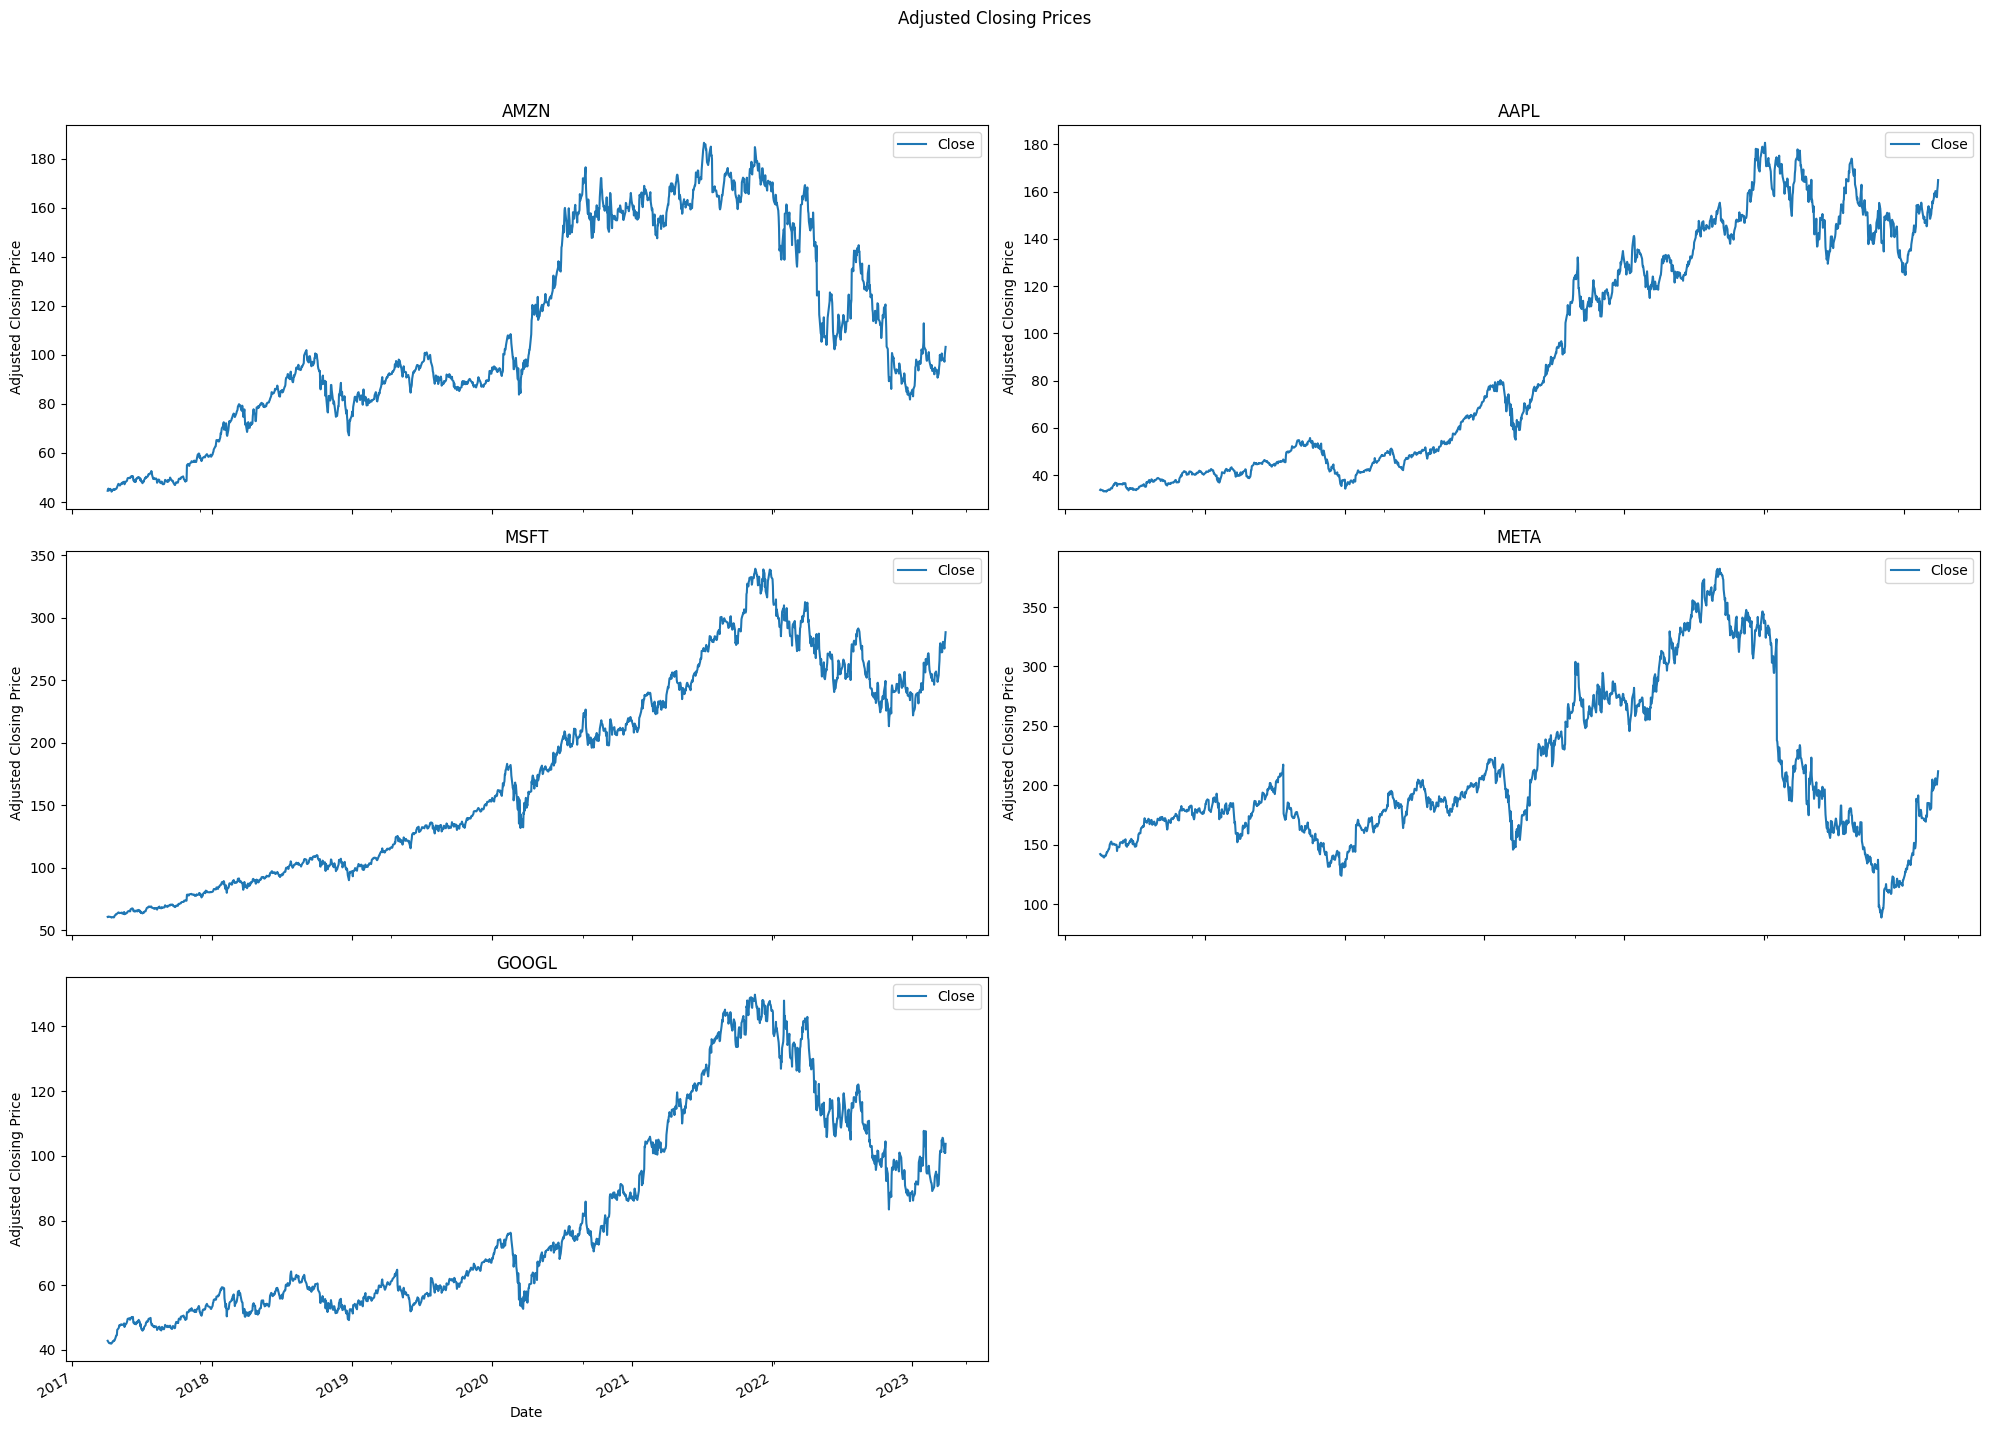

In [4]:
#Here we will plot the Closing prices for each company to see there trends over the last 6 years

AdjClose = data.loc[:,(slice(None), 'Close')] # Extracting adj close prices
numrows = len(tickers) // 2 + len(tickers) % 2 # defining number of rows and columns for the subplots
numcols = 2

fig, axs = plt.subplots(nrows= numrows, ncols = numcols, figsize = (20,15), sharex = True)
fig.suptitle('Adjusted Closing Prices')

axs_flat = axs.flatten() #this will convert 2d axes array to 1d for easier iteration over the axes

for i, ticker in enumerate(tickers):
    AdjClose[ticker].plot(ax=axs_flat[i], title = ticker)
    axs_flat[i].set_xlabel('Date')
    axs_flat[i].set_ylabel('Adjusted Closing Price')

# Remove the extra unused subplot
fig.delaxes(axs_flat[-1])

#layout spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

 

Observations from the above graphs obtained:
1. The adjusted closing prices for each company have increased over time especially between the time period 2020-2021 (Covid 19)
2. We can see a sudden downtrend between the time period 2022-2023 for META.
3. Google has generally had the highest adjusted closing prices among the five companies, while Meta (formerly Facebook) has generally had the lowest.
4. Apple's adjusted closing prices appear to be the most volatile, with more frequent spikes and dips compared to the other companies.
5. (Inflection Points) There are some periods of time where the adjusted closing prices for all five companies move in the same direction, such as during market-wide trends or events (for example during covid-19). Conversely, there may be other periods where the companies' prices move in opposite directions or have different levels of volatility.

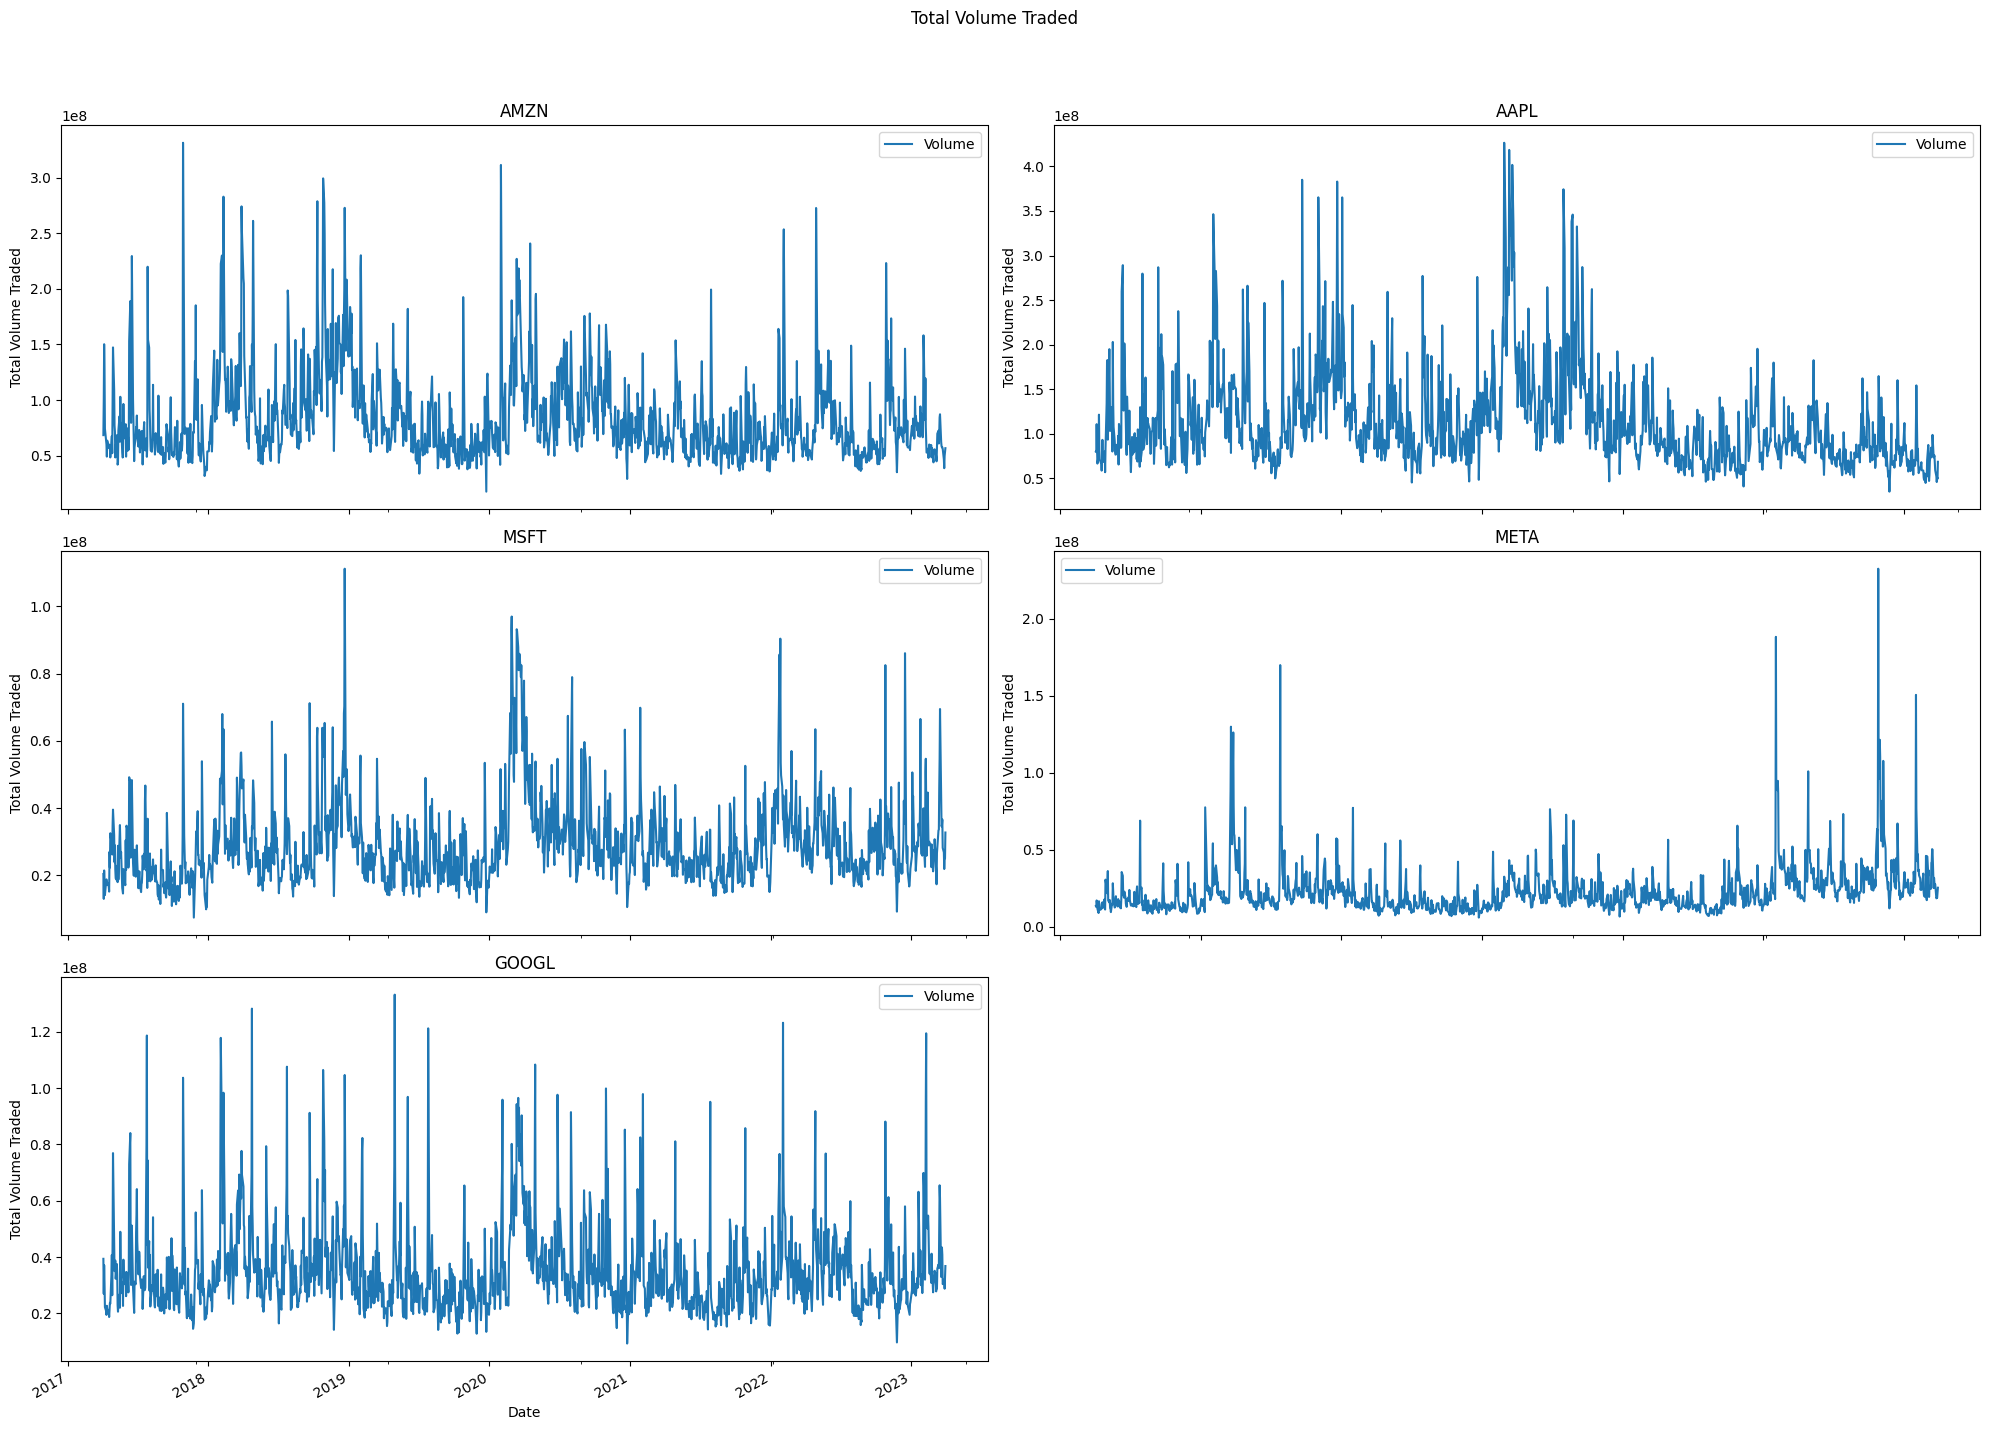

In [5]:
#If we want to analyse the total volume of the stock traded we can do that by plotting it 

VolTraded = data.loc[:,(slice(None), 'Volume')]
numrows = len(tickers) // 2 + len(tickers) % 2 # defining number of rows and columns for the subplots
numcols = 2

fig, axs = plt.subplots(nrows= numrows, ncols = numcols, figsize = (20,15), sharex = True)
fig.suptitle('Total Volume Traded')

axs_flat = axs.flatten() #this will convert 2d axes array to 1d for easier iteration over the axes

for i, ticker in enumerate(tickers):
    VolTraded[ticker].plot(ax=axs_flat[i], title = ticker)
    axs_flat[i].set_xlabel('Date')
    axs_flat[i].set_ylabel('Total Volume Traded')

# Remove the extra unused subplot
fig.delaxes(axs_flat[-1])

#layout spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


1. The above plots shows us the total volume traded for company over a specific date range.
2. The sudden spikes and drops in the above plots shows the important market events that impacted the comapnies correspondingly.
3. We can compare the relative liquidity of each stock, the higher average trading volumes are considered more liquid indicating that it is much easier to sell or buy the shares without having an impact on the stock price.

Calculating Moving Average of the Adjusted Closing Prices for the companies 

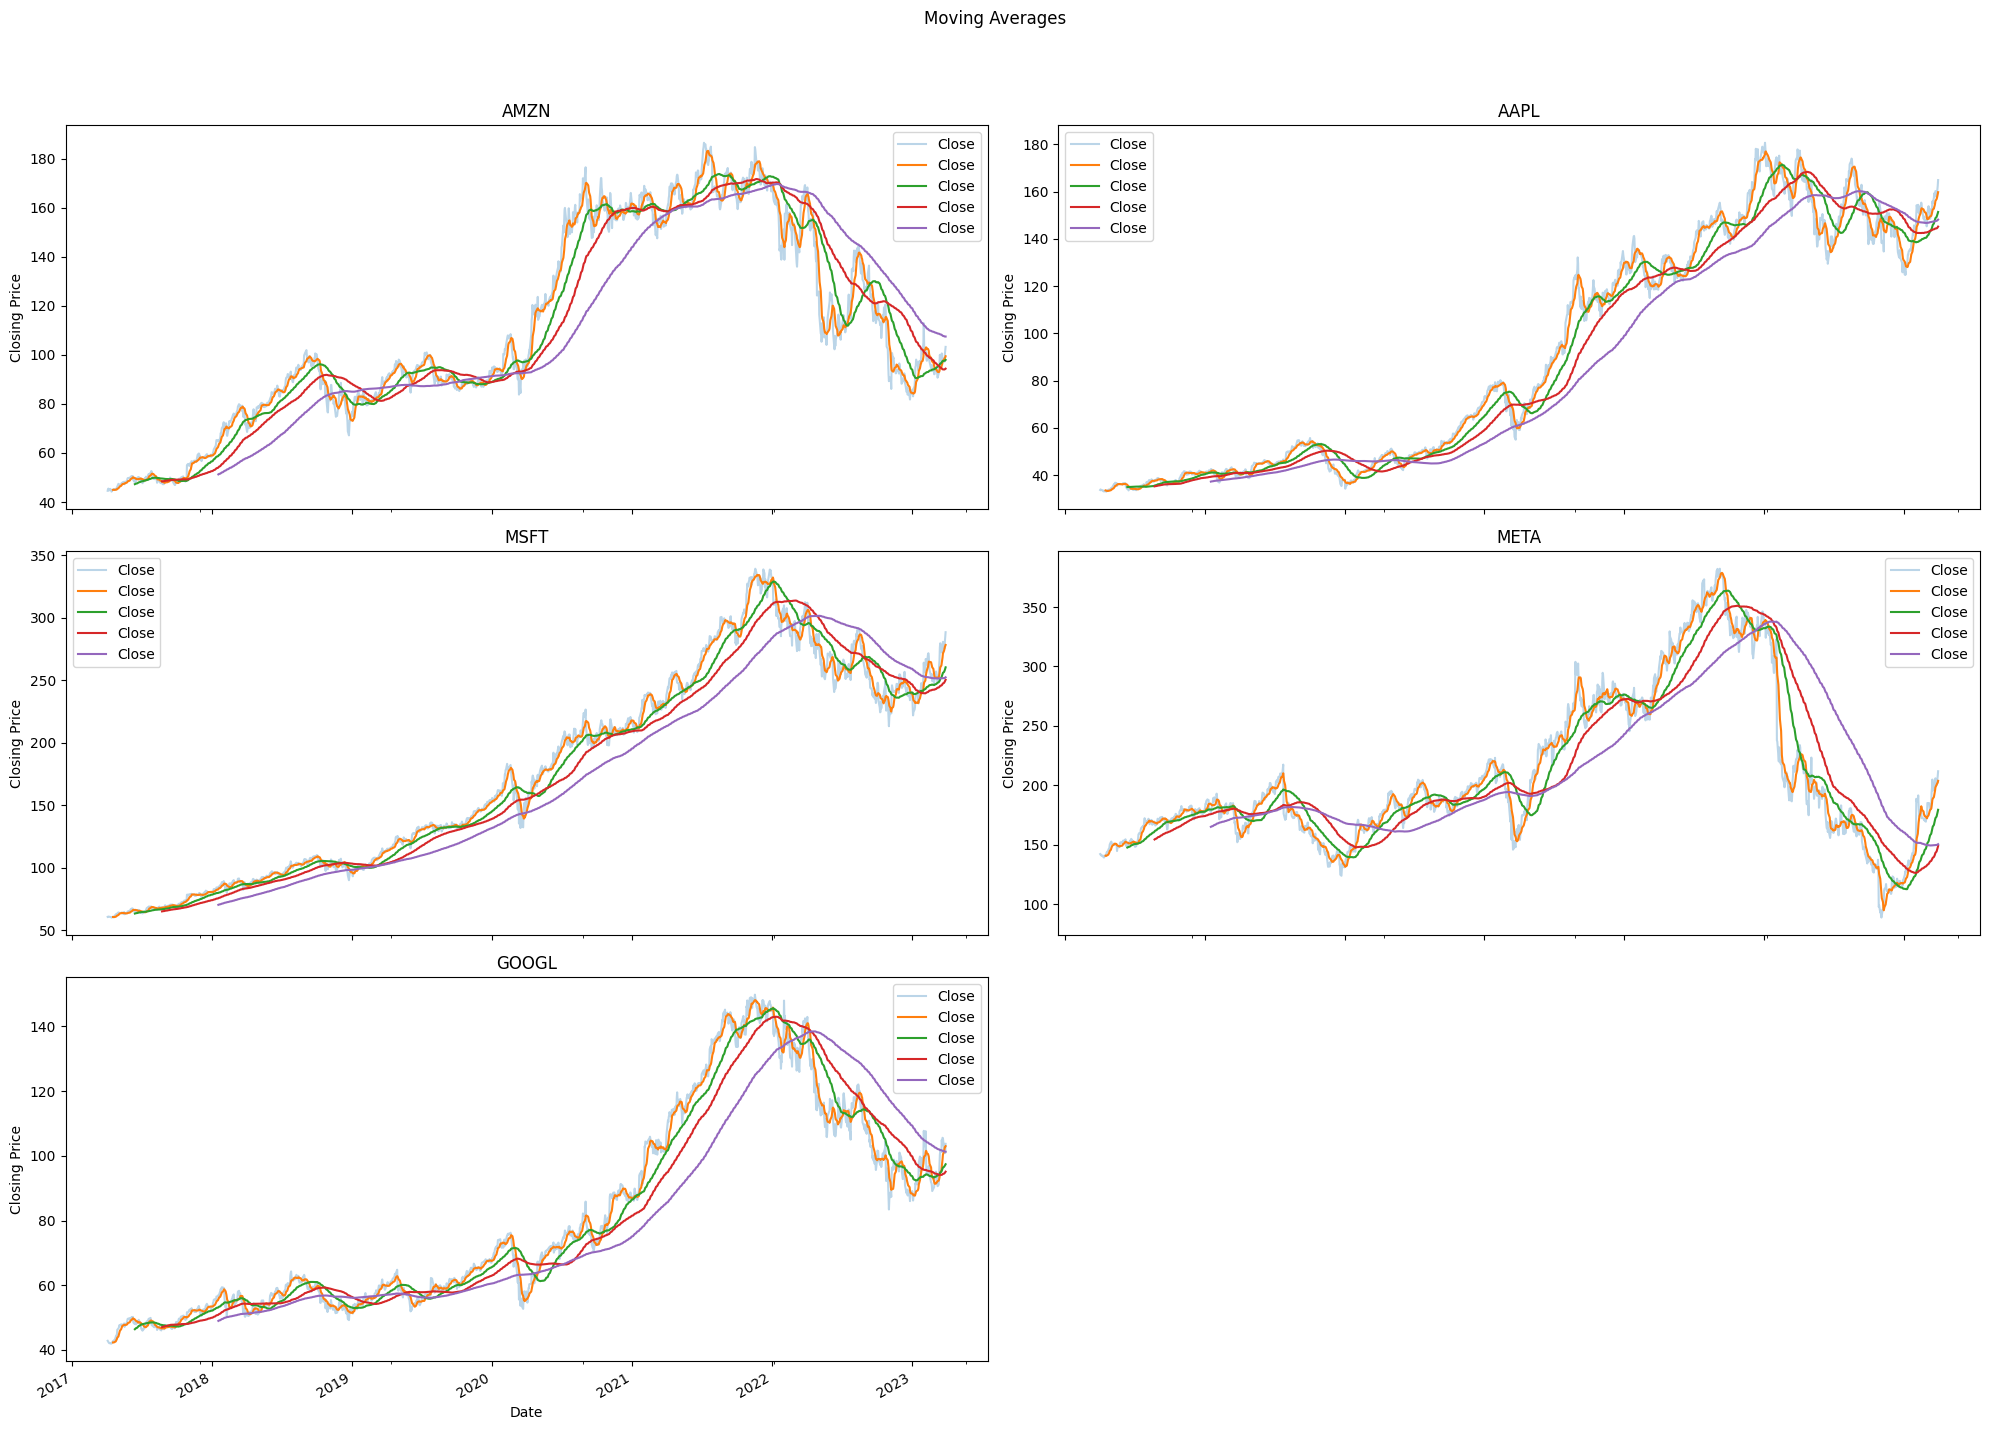

In [6]:
 # Calculate the moving averages of the Closing price
MA = [10, 50, 100, 200]
AdjClose = data.loc[:, (slice(None), 'Close')]

# Define the number of rows and columns for the subplots
numrows = len(tickers) // 2 + len(tickers) % 2
numcols = 2

fig, axs = plt.subplots(nrows=numrows, ncols=numcols, figsize=(20, 15), sharex=True)
fig.suptitle('Moving Averages')

# Loop through each ticker
for i, ticker in enumerate(tickers):
    ax = axs[i // numcols, i % numcols]
    
    # Plot the original closing prices
    AdjClose[ticker].plot(ax=ax, alpha=0.3, label='Closing Price')

    # Calculate and plot the moving averages
    for ma in MA:
        ma_series = AdjClose[ticker].rolling(window=ma).mean()
        ma_series.plot(ax=ax, label=f'MA {ma} days')

    ax.set_title(ticker)
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing Price')
    ax.legend()

# Remove the extra unused subplot
axs[-1, -1].axis('off')

# Adjust layout for better spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


This code snippet calculates and plots the moving averages (MA) of the closing prices for the specified stock tickers, along with the original closing prices. The moving averages are calculated for 10, 50, 100, and 200-day windows.

The code first extracts the adjusted closing price for each stock into a new DataFrame called AdjClose by selecting the 'Close' columns for all tickers using .loc[].
It sets the number of rows and columns for the subplots based on the number of tickers.
The code creates a figure with multiple subplots using plt.subplots(), sharing the x-axis and setting an appropriate figure size.
It then loops through each ticker and creates a subplot for each:
a. The original adjusted closing prices are plotted with an alpha value of 0.3 (for transparency).
b. For each moving average window (10, 50, 100, and 200 days), the code calculates the rolling mean using .rolling(window=ma).mean() and plots the result on the same subplot.
c. The subplot is labeled with the ticker name, axis labels, and a legend.
The last unused subplot is removed with axs[-1, -1].axis('off').
The layout is adjusted for better spacing using fig.tight_layout(), and the figure is displayed with plt.show()

1. Calculating moving average helps us to understand the overall trend of the stock price, rising moving average indicates an uptrend and vica versa
2. When a stock price is above the moving average it signifies that the stocks can be bought that is it acts as support level whereas if the stock price approaches from below it indicates resistance from the moving average.

Calculating the RSI(Relative Strength Indicator) and Moving Average Convergence Divergence (MACD)

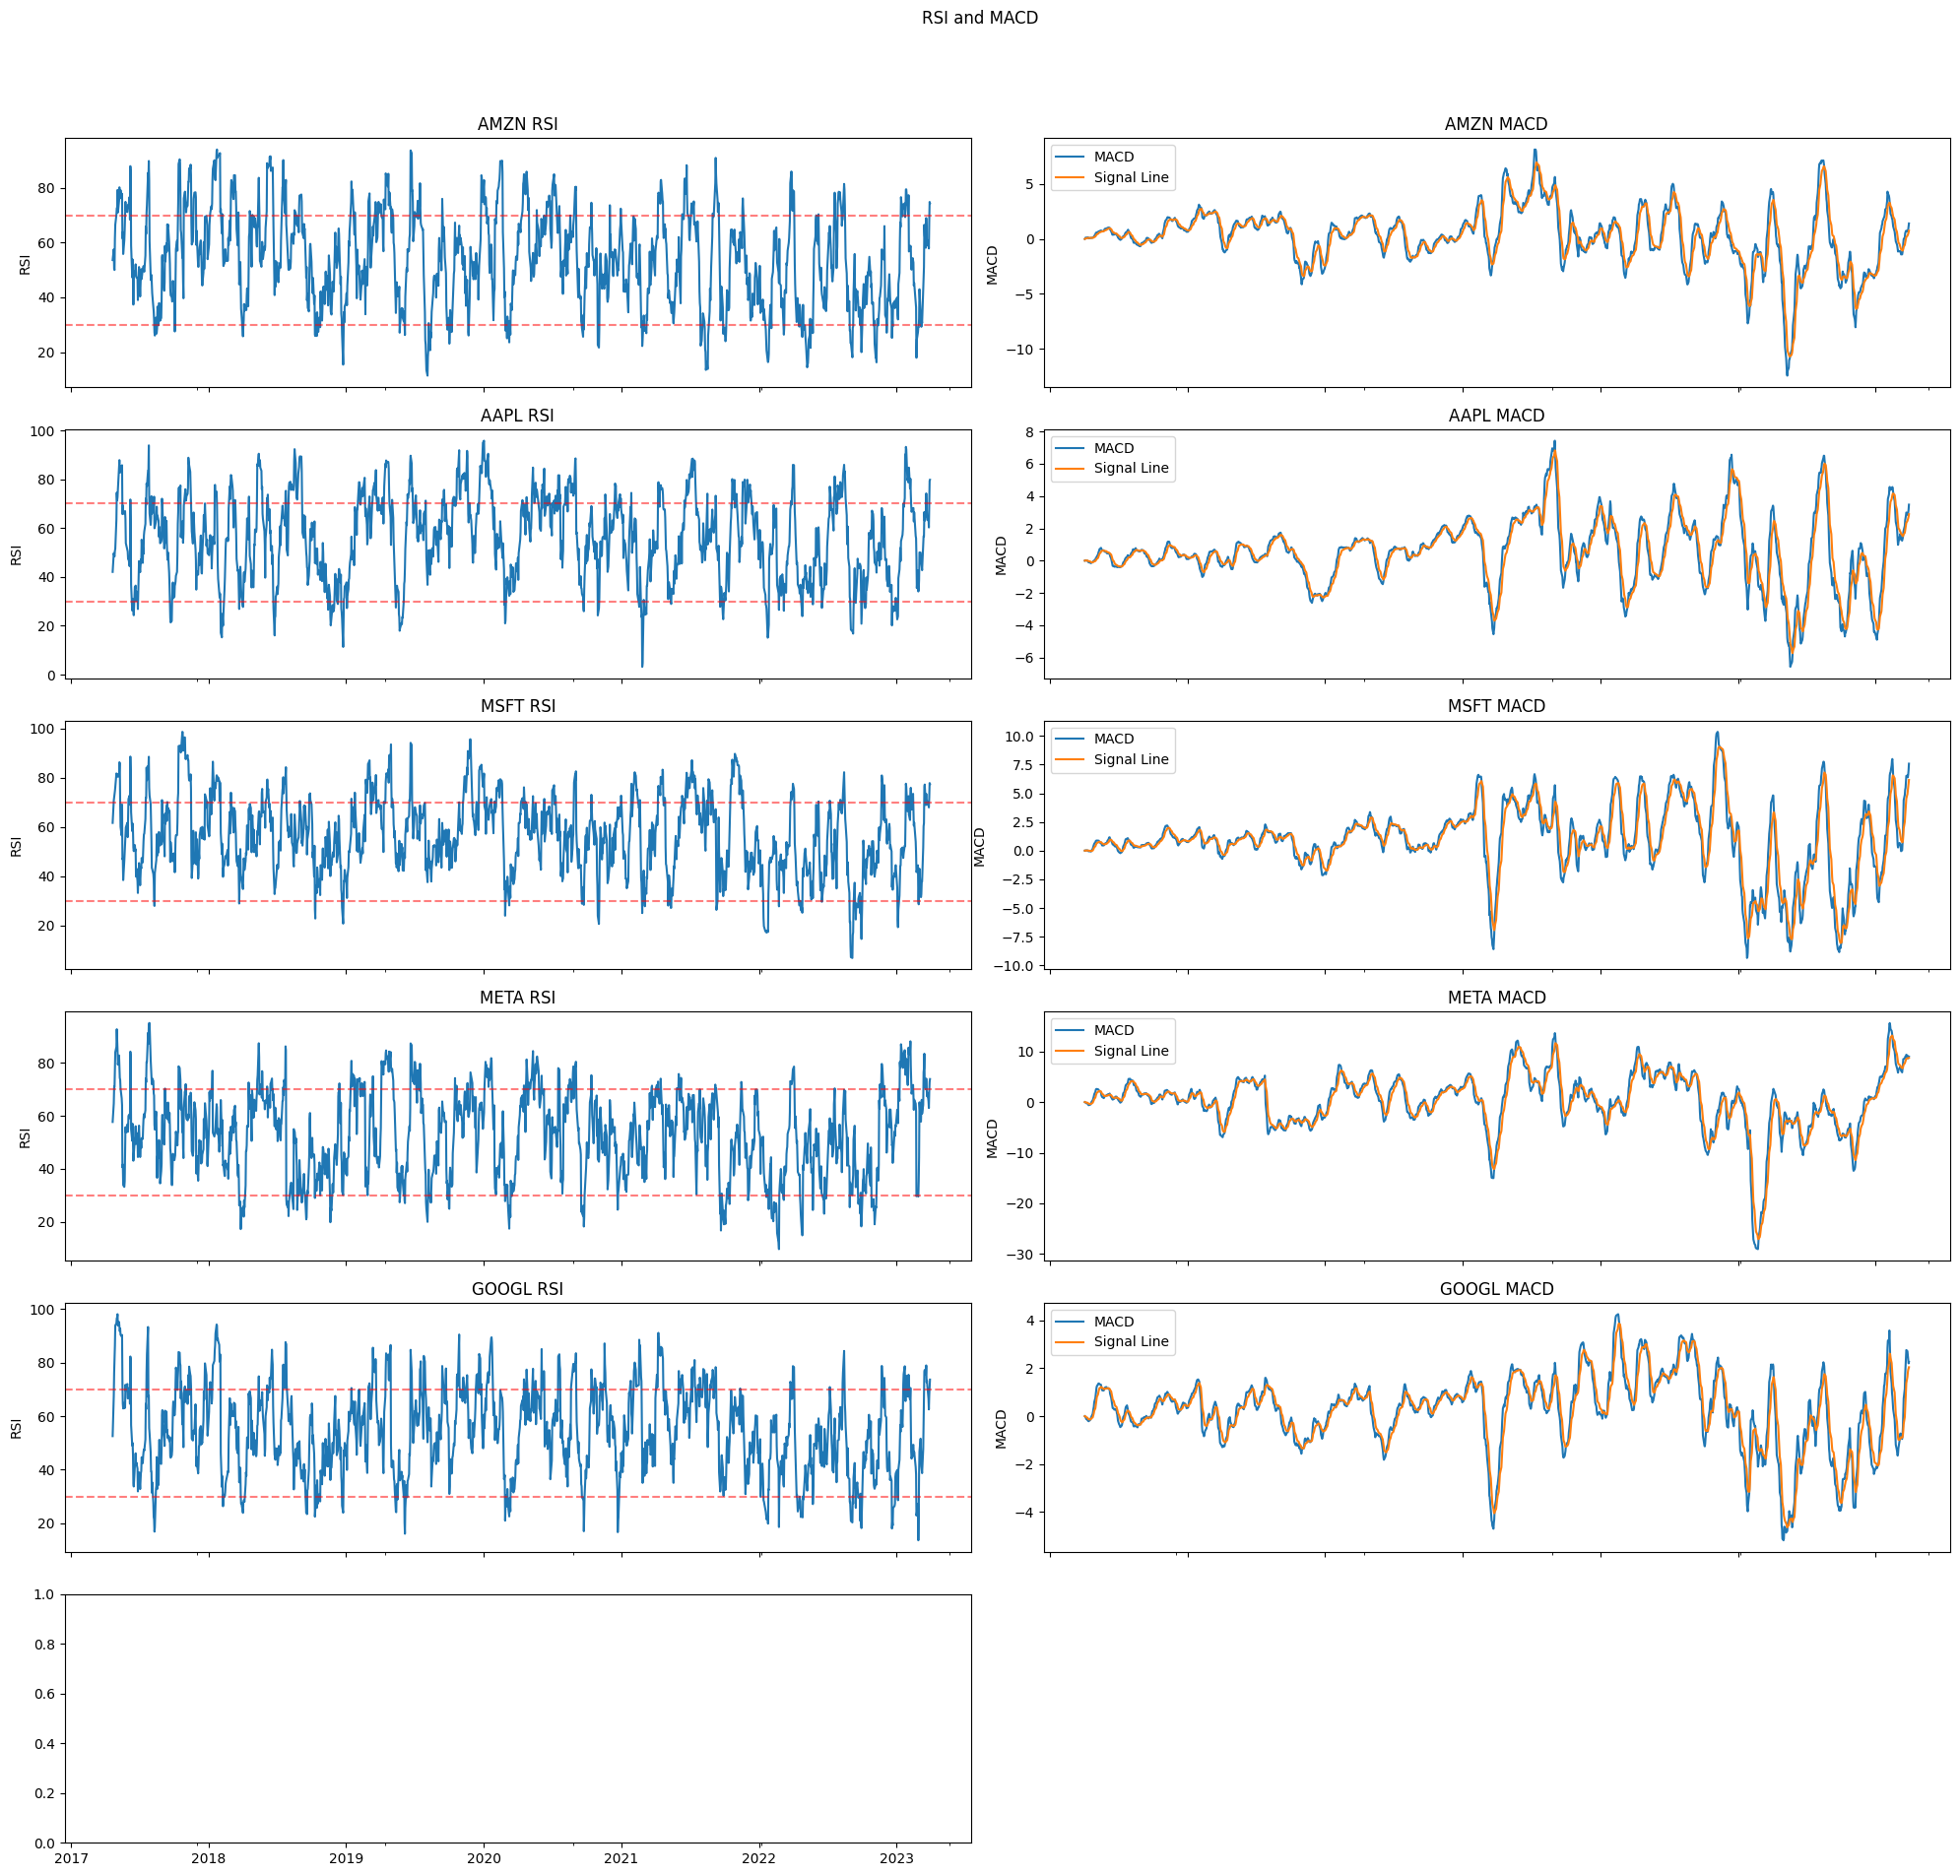

In [7]:
 # Calculate RSI
def rsi(data, period=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate MACD
def macd(data, short_period=12, long_period=26, signal_period=9):
    short_ema = data['Close'].ewm(span=short_period, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_period, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

# Plot RSI and MACD for each company
numrows = len(tickers) // 2 + len(tickers) % 2
numcols = 2

fig, axs = plt.subplots(nrows=numrows*2, ncols=numcols, figsize=(20, 20), sharex=True)
fig.suptitle('RSI and MACD')
axs_flat = axs.flatten()

for i, ticker in enumerate(tickers):
    # RSI plot
    rsi_data = rsi(data[ticker])
    rsi_data.plot(ax=axs_flat[i*2], title=f'{ticker} RSI')
    axs_flat[i*2].axhline(30, color='red', linestyle='--', alpha=0.5)
    axs_flat[i*2].axhline(70, color='red', linestyle='--', alpha=0.5)
    axs_flat[i*2].set_xlabel('Date')
    axs_flat[i*2].set_ylabel('RSI') 

# Remove the extra unused subplot
axs[-1, -1].axis('off')

for i, ticker in enumerate(tickers):
    # MACD plot
    macd_line, signal_line = macd(data[ticker])
    macd_line.plot(ax=axs_flat[i*2+1], title=f'{ticker} MACD', label='MACD')
    signal_line.plot(ax=axs_flat[i*2+1], label='Signal Line')
    axs_flat[i*2+1].set_xlabel('Date')
    axs_flat[i*2+1].set_ylabel('MACD')
    axs_flat[i*2+1].legend()

# Remove the extra unused subplot
axs[-1, -1].axis('off')

# Adjust layout for better spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

This code snippet defines two functions, rsi() and macd(), to calculate the Relative Strength Index (RSI) and Moving Average Convergence Divergence (MACD) indicators for the stock data. It then plots the RSI and MACD values for each ticker in separate subplots.

The rsi() function takes the input stock data and a period (default is 14) to calculate the RSI values. It computes the gains and losses in the stock's closing prices and calculates their average values over the specified period. The RSI is calculated using these average values.

The macd() function calculates the MACD indicator by taking the input stock data, short-period EMA (default is 12), long-period EMA (default is 26), and the signal line period (default is 9). It computes the short and long EMAs and derives the MACD line by subtracting the long EMA from the short EMA. The signal line is calculated as the EMA of the MACD line over the specified signal period.

The code then creates a figure with multiple subplots to visualize the RSI and MACD indicators for each ticker. It loops through the tickers and plots the RSI and MACD values in separate subplots. For the RSI plot, it also adds horizontal lines at 30 and 70 to indicate oversold and overbought levels. The MACD plot includes both the MACD line and the signal line. The subplots are labeled with the ticker name, axis labels, and a legend.

Finally, any unused subplots are removed, and the layout is adjusted for better spacing using fig.tight_layout(). The figure is displayed with plt.show().

In summary, this code snippet calculates the RSI and MACD indicators for the given stock data and visualizes them in separate subplots for each ticker, providing insight into the stocks' momentum and trend-following characteristics.

Relative Strength Index-
1. It is a momentum indicator
2. Basic formula => RSI = 100 - (100 / (1 + RS)) where RS represents the average gain or average loss.
3. The above plot shows the Relative Strength Index for each company using the adjusted close price data. If the RSI value for a company is above 70- it indicated that it is a good time for selling stocks and below 30 indicated good time to consider for buying a stock.
4. From the MACD graphs, we can see the trend of each company's stock momentum, as well as the buy and sell signals that can be derived from the MACD Line and Signal Line crossovers. The MACD Histogram also provides an indication of the strength of the trend, with positive values indicating an uptrend and negative values indicating a downtrend.

In [8]:
def bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band


In [9]:
def plot_bollinger_bands(data, ticker, window=20, num_std=2):
    upper_band, lower_band = bollinger_bands(data, window, num_std)
    plt.figure(figsize=(15, 8))
    plt.plot(data.index, data['Close'], label=f'{ticker} Close Price', color='blue')
    plt.plot(data.index, upper_band, label='Upper Band', color='red')
    plt.plot(data.index, lower_band, label='Lower Band', color='green')
    plt.fill_between(data.index, upper_band, lower_band, color='grey', alpha=0.3)
    plt.title(f'{ticker} Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()




Combine the original closing prices with the calculated technical indicators (moving averages, MACD, and RSI) to create a feature set for each stock:

                                Open       High        Low      Close  \
Date                                                                    
2018-01-17 00:00:00-05:00  65.612000  65.699997  64.043999  64.750000   
2018-01-18 00:00:00-05:00  64.697502  65.230003  64.200996  64.666000   
2018-01-19 00:00:00-05:00  65.599998  65.650002  64.649498  64.728996   
2018-01-22 00:00:00-05:00  64.858498  66.372498  64.833000  66.365501   
2018-01-23 00:00:00-05:00  66.904503  68.245003  66.866997  68.126999   

                              Volume  Dividends  Stock Splits      MA_10  \
Date                                                                       
2018-01-17 00:00:00-05:00  105076000        0.0           0.0  62.892849   
2018-01-18 00:00:00-05:00   80538000        0.0           0.0  63.338449   
2018-01-19 00:00:00-05:00   91570000        0.0           0.0  63.763399   
2018-01-22 00:00:00-05:00   82802000        0.0           0.0  64.254249   
2018-01-23 00:00:00-05:00  10338

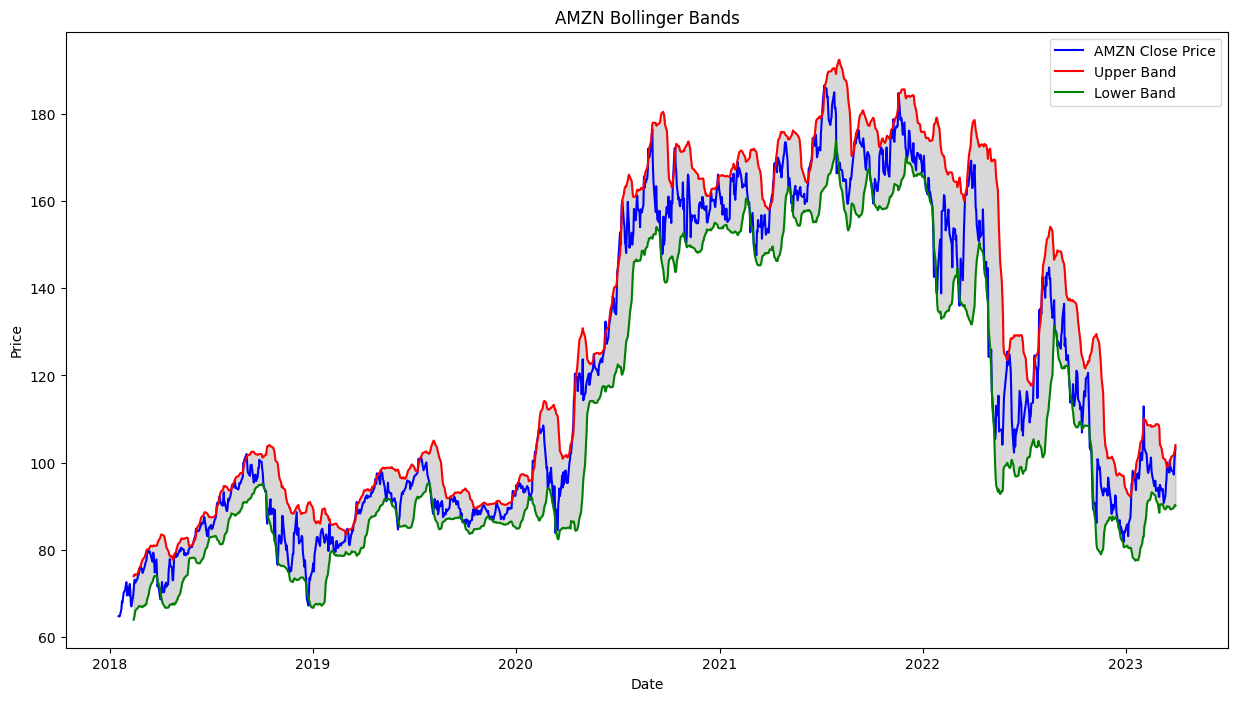

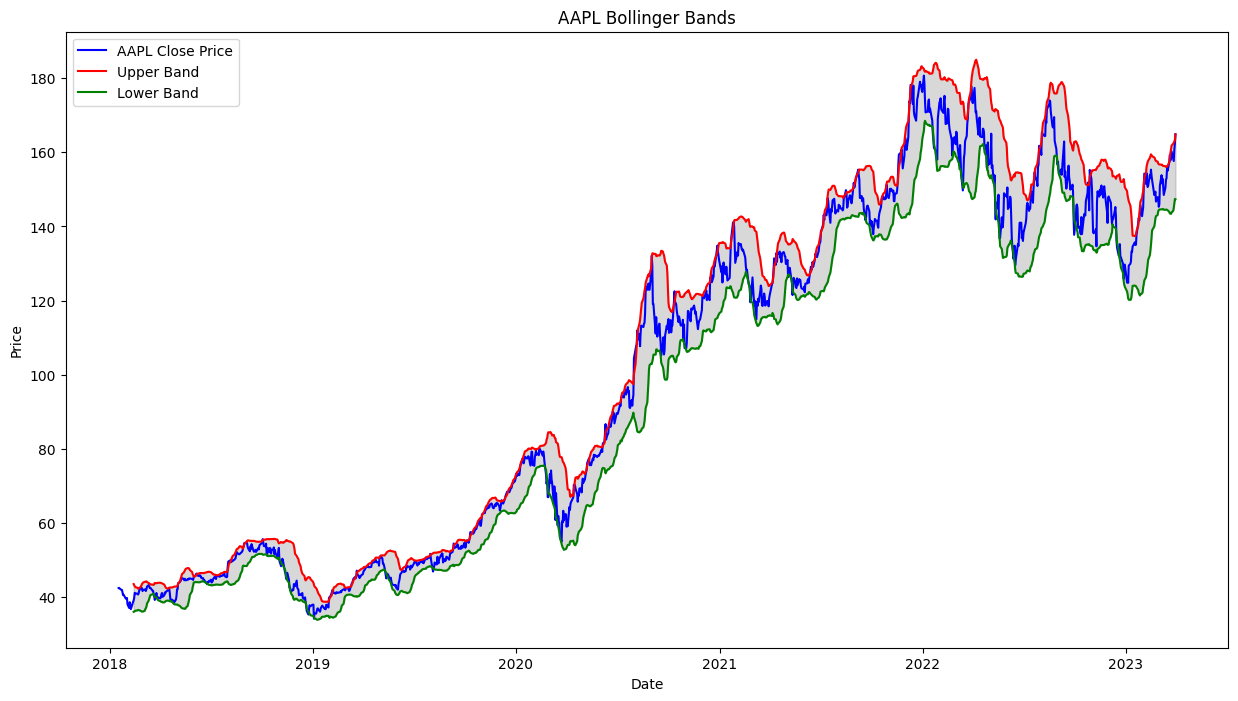

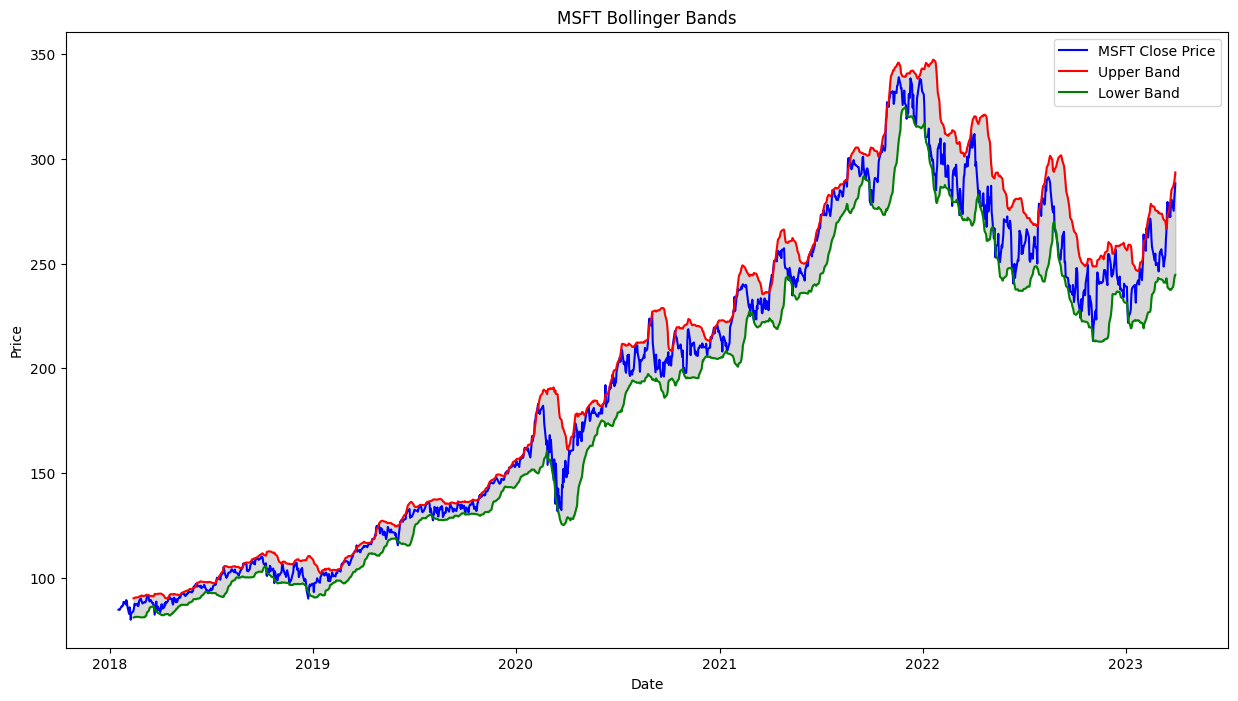

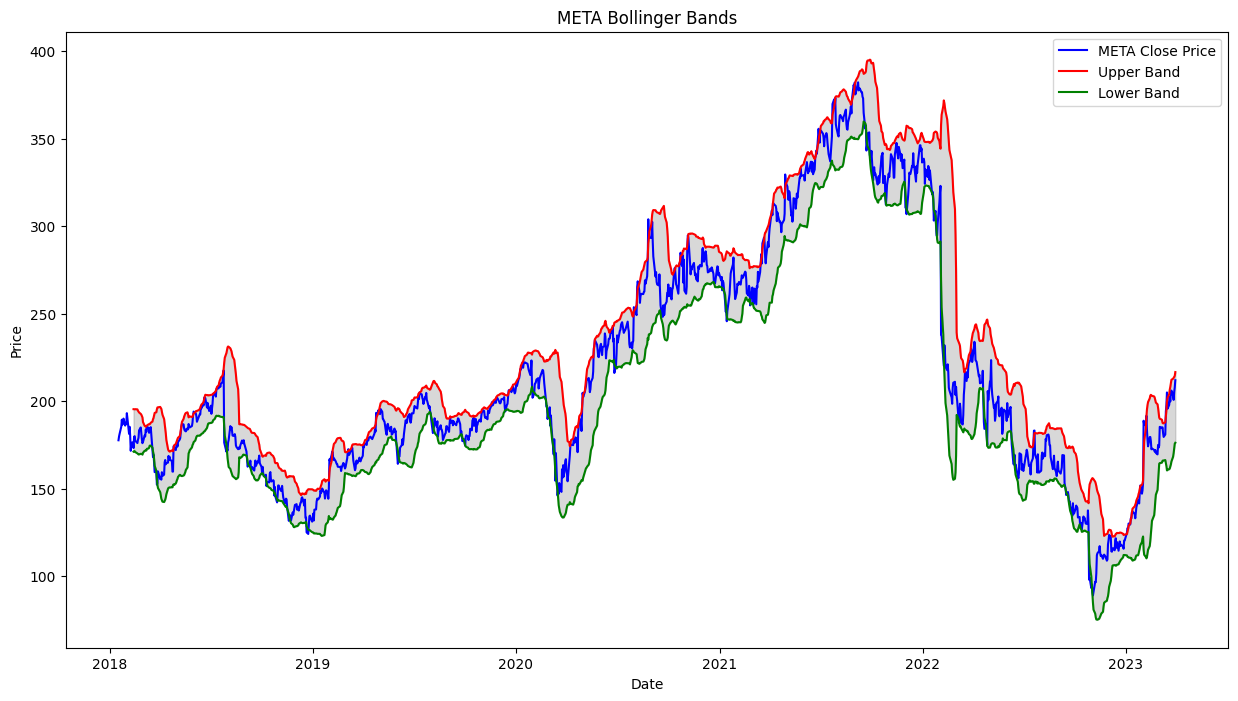

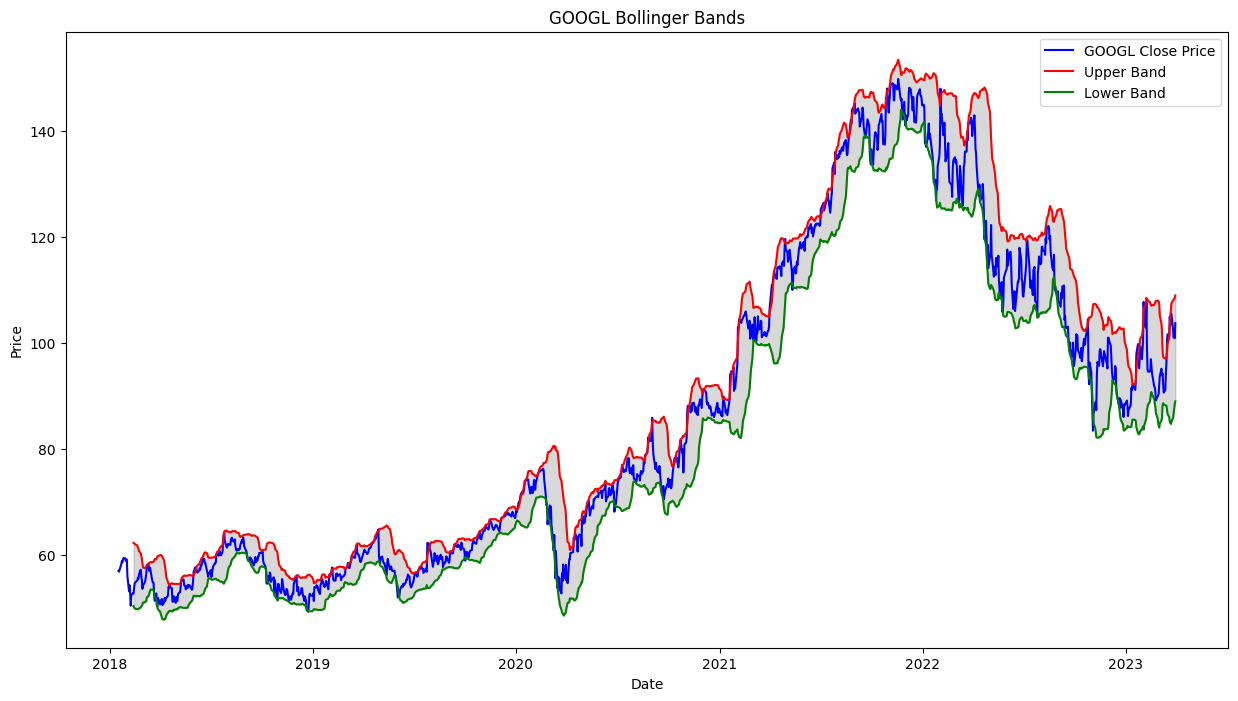

In [10]:
def addMA(data, MA):
    for ma in MA:
        data[f'MA_{ma}'] = data['Close'].rolling(window=ma).mean()
    return data
MA = [10,50,100,200]
#adding moving averages, RSI and MACD to our stock data
featureSets = {}
for ticker in tickers:
    stockFeatures = data[ticker].copy()
    stockFeatures = addMA(stockFeatures, MA)
    stockFeatures['RSI'] = rsi(stockFeatures)
    stockFeatures['MACD'], stockFeatures['Signal Line'] = macd(stockFeatures)
    # Calculate and add Bollinger Bands
    upper_band, lower_band = bollinger_bands(stockFeatures)
    stockFeatures['Upper Band'] = upper_band
    stockFeatures['Lower Band'] = lower_band
    featureSets[ticker] = stockFeatures.dropna()

print(featureSets['AMZN'].head())
print(featureSets['AAPL'].head())
print(featureSets['MSFT'].head())
print(featureSets['META'].head())
print(featureSets['GOOGL'].head())

for ticker in tickers:
    stock_data = featureSets[ticker]
    plot_bollinger_bands(stock_data, ticker)

Implement a function that creates input-output pairs of sequences for each stock using the sliding window approach. The function should take the feature set, lookback window size, and target column (e.g., Opening Price) as input and return input-output pairs (X, y).

In [11]:
def seq(data,lookback, targetCol ='Open'):
    X, y =[],[]
    for i in range (lookback, len(data)):
        X.append(data.iloc[i - lookback:i].values)
        y.append(data.iloc[i][targetCol])
    return np.array(X), np.array(y)

lookback = 60

InputOutput = {}

for ticker in tickers:
    X, y = seq(featureSets[ticker],lookback, targetCol ='Open')
    InputOutput[ticker]= {'X': X, 'y':y}

print("AMZN input shape:", InputOutput['AMZN']['X'].shape)
print("AMZN output shape:", InputOutput['AMZN']['y'].shape)
print("AAPL input shape:", InputOutput['AAPL']['X'].shape)
print("AAPL output shape:", InputOutput['AAPL']['y'].shape)
print("MSFT input shape:", InputOutput['MSFT']['X'].shape)
print("MSFT output shape:", InputOutput['MSFT']['y'].shape)
print("META input shape:", InputOutput['META']['X'].shape)
print("META output shape:", InputOutput['META']['y'].shape)
print("GOOGL input shape:", InputOutput['GOOGL']['X'].shape)
print("GOOGL output shape:", InputOutput['GOOGL']['y'].shape)

AMZN input shape: (1251, 60, 16)
AMZN output shape: (1251,)
AAPL input shape: (1251, 60, 16)
AAPL output shape: (1251,)
MSFT input shape: (1251, 60, 16)
MSFT output shape: (1251,)
META input shape: (1251, 60, 16)
META output shape: (1251,)
GOOGL input shape: (1251, 60, 16)
GOOGL output shape: (1251,)


Normalize the Data

In [12]:
ScalerFeatures = MinMaxScaler()
ScalerResponse = MinMaxScaler()

scaledIO = {}

for ticker in tickers:
    X = InputOutput[ticker]['X']
    y = InputOutput[ticker]['y']
    y = y.reshape(-1, 1)

    # scaling the input features
    sample, timesteps, features = X.shape
    X = X.reshape(sample, -1)
    ScalerFeatures.fit(X)
    X = ScalerFeatures.transform(X)
    X = X.reshape(sample, timesteps, features)

    # scaling response variable
    ScalerResponse.fit(y)
    y = ScalerResponse.transform(y)

    scaledIO[ticker] = {'X': X, 'y': y}

print("AMZN input shape:", scaledIO['AMZN']['X'].shape)
print("AMZN output shape:", scaledIO['AMZN']['y'].shape)
print("AAPL input shape:", scaledIO['AAPL']['X'].shape)
print("AAPL output shape:", scaledIO['AAPL']['y'].shape)
print("MSFT input shape:", scaledIO['MSFT']['X'].shape)
print("MSFT output shape:", scaledIO['MSFT']['y'].shape)
print("META input shape:", scaledIO['META']['X'].shape)
print("META output shape:", scaledIO['META']['y'].shape)
print("GOOGL input shape:", scaledIO['GOOGL']['X'].shape)
print("GOOGL output shape:", scaledIO['GOOGL']['y'].shape)


AMZN input shape: (1251, 60, 16)
AMZN output shape: (1251, 1)
AAPL input shape: (1251, 60, 16)
AAPL output shape: (1251, 1)
MSFT input shape: (1251, 60, 16)
MSFT output shape: (1251, 1)
META input shape: (1251, 60, 16)
META output shape: (1251, 1)
GOOGL input shape: (1251, 60, 16)
GOOGL output shape: (1251, 1)


To perform a train-test split for each stock while maintaining the time series order, you can follow the steps below:

In [13]:
dataSplit = (0.6,0.2,0.2)
Split_Data = {}

for ticker in tickers:
    X = scaledIO[ticker]['X']
    y = scaledIO[ticker]['y']

    train_split = int(X.shape[0] * dataSplit[0])
    valid_split = train_split + int(X.shape[0] * dataSplit[1])

    X_train = X[:train_split]
    y_train = y[:train_split]
    X_val = X[train_split:valid_split]
    y_val = y[train_split:valid_split]
    X_test = X[valid_split:]
    y_test = y[valid_split:]

    Split_Data[ticker] = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val, 'X_test': X_test, 'y_test': y_test}

print("AMZN X_train :", Split_Data['AMZN']['X_train'].shape)
print("AMZN y_train :", Split_Data['AMZN']['y_train'].shape)
print("AMZN X_val :", Split_Data['AMZN']['X_val'].shape)
print("AMZN y_val :", Split_Data['AMZN']['y_val'].shape)
print("AMZN X_test :", Split_Data['AMZN']['X_test'].shape)
print("AMZN y_test :", Split_Data['AMZN']['y_test'].shape)

print("AAPL X_train :", Split_Data['AAPL']['X_train'].shape)
print("AAPL y_train :", Split_Data['AAPL']['y_train'].shape)
print("AAPL X_val :", Split_Data['AAPL']['X_val'].shape)
print("AAPL y_val :", Split_Data['AAPL']['y_val'].shape)
print("AAPL X_test :", Split_Data['AAPL']['X_test'].shape)
print("AAPL y_test :", Split_Data['AAPL']['y_test'].shape)

print("MSFT X_train :", Split_Data['MSFT']['X_train'].shape)
print("MSFT y_train :", Split_Data['MSFT']['y_train'].shape)
print("MSFT X_val :", Split_Data['MSFT']['X_val'].shape)
print("MSFT y_val :", Split_Data['MSFT']['y_val'].shape)
print("MSFT X_test :", Split_Data['MSFT']['X_test'].shape)
print("MSFT y_test :", Split_Data['MSFT']['y_test'].shape)

print("META X_train :", Split_Data['META']['X_train'].shape)
print("META y_train :", Split_Data['META']['y_train'].shape)
print("META X_val :", Split_Data['META']['X_val'].shape)
print("META y_val :", Split_Data['META']['y_val'].shape)
print("META X_test :", Split_Data['META']['X_test'].shape)
print("META y_test :", Split_Data['META']['y_test'].shape)

print("GOOGL X_train :", Split_Data['GOOGL']['X_train'].shape)
print("GOOGL y_train :", Split_Data['GOOGL']['y_train'].shape)
print("GOOGL X_val :", Split_Data['GOOGL']['X_val'].shape)
print("GOOGL y_val :", Split_Data['GOOGL']['y_val'].shape)
print("GOOGL X_test :", Split_Data['GOOGL']['X_test'].shape)
print("GOOGL y_test :", Split_Data['GOOGL']['y_test'].shape)
 

AMZN X_train : (750, 60, 16)
AMZN y_train : (750, 1)
AMZN X_val : (250, 60, 16)
AMZN y_val : (250, 1)
AMZN X_test : (251, 60, 16)
AMZN y_test : (251, 1)
AAPL X_train : (750, 60, 16)
AAPL y_train : (750, 1)
AAPL X_val : (250, 60, 16)
AAPL y_val : (250, 1)
AAPL X_test : (251, 60, 16)
AAPL y_test : (251, 1)
MSFT X_train : (750, 60, 16)
MSFT y_train : (750, 1)
MSFT X_val : (250, 60, 16)
MSFT y_val : (250, 1)
MSFT X_test : (251, 60, 16)
MSFT y_test : (251, 1)
META X_train : (750, 60, 16)
META y_train : (750, 1)
META X_val : (250, 60, 16)
META y_val : (250, 1)
META X_test : (251, 60, 16)
META y_test : (251, 1)
GOOGL X_train : (750, 60, 16)
GOOGL y_train : (750, 1)
GOOGL X_val : (250, 60, 16)
GOOGL y_val : (250, 1)
GOOGL X_test : (251, 60, 16)
GOOGL y_test : (251, 1)


Crosschecking for null values in the dataset

In [14]:
for ticker in tickers:
    print(f"{ticker} X_train null values: {np.isnan(Split_Data[ticker]['X_train']).sum()}")
    print(f"{ticker} y_train null values: {np.isnan(Split_Data[ticker]['y_train']).sum()}")
    print(f"{ticker} X_val null values: {np.isnan(Split_Data[ticker]['X_val']).sum()}")
    print(f"{ticker} y_val null values: {np.isnan(Split_Data[ticker]['y_val']).sum()}")
    print(f"{ticker} X_test null values: {np.isnan(Split_Data[ticker]['X_test']).sum()}")
    print(f"{ticker} y_test null values: {np.isnan(Split_Data[ticker]['y_test']).sum()}")


AMZN X_train null values: 0
AMZN y_train null values: 0
AMZN X_val null values: 0
AMZN y_val null values: 0
AMZN X_test null values: 0
AMZN y_test null values: 0
AAPL X_train null values: 0
AAPL y_train null values: 0
AAPL X_val null values: 0
AAPL y_val null values: 0
AAPL X_test null values: 0
AAPL y_test null values: 0
MSFT X_train null values: 0
MSFT y_train null values: 0
MSFT X_val null values: 0
MSFT y_val null values: 0
MSFT X_test null values: 0
MSFT y_test null values: 0
META X_train null values: 0
META y_train null values: 0
META X_val null values: 0
META y_val null values: 0
META X_test null values: 0
META y_test null values: 0
GOOGL X_train null values: 0
GOOGL y_train null values: 0
GOOGL X_val null values: 0
GOOGL y_val null values: 0
GOOGL X_test null values: 0
GOOGL y_test null values: 0


We can see there are no null values in out dataset, now we can proceed to build our model

Processing AMZN.....
Epoch 1/100
24/24 [==============================] - 4s 62ms/step - loss: 0.0272 - val_loss: 0.0142
Epoch 2/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0077 - val_loss: 0.0047
Epoch 3/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0046 - val_loss: 0.0076
Epoch 4/100
24/24 [==============================] - 1s 32ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 5/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 6/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 7/100
24/24 [==============================] - 1s 32ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 8/100
24/24 [==============================] - 1s 33ms/step - loss: 0.0039 - val_loss: 0.0086
Epoch 9/100
24/24 [==============================] - 1s 34ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 10/100
24/24 [==============================] - 1s 35ms/step - loss: 0.00

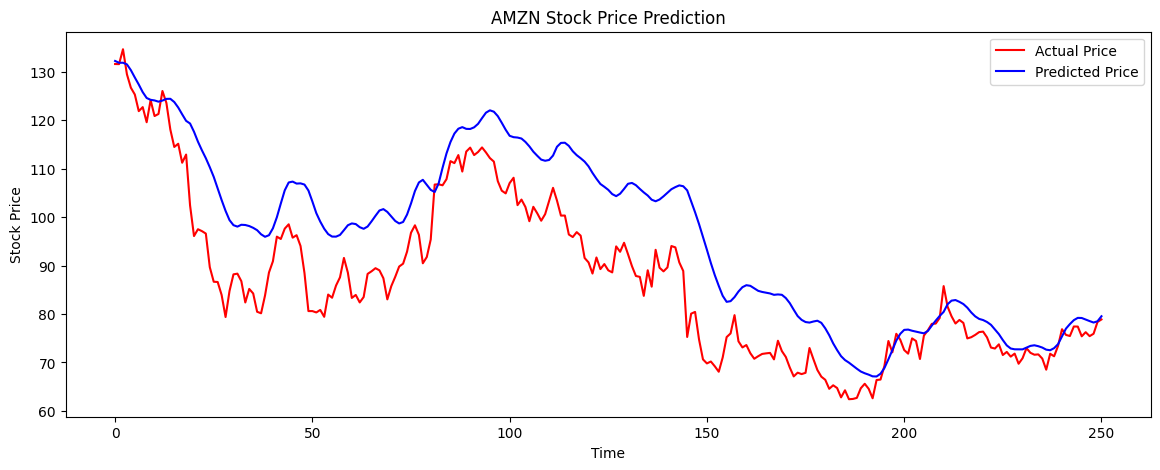

Processing AAPL.....
Epoch 1/100
24/24 [==============================] - 4s 59ms/step - loss: 0.0127 - val_loss: 0.0359
Epoch 2/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0026 - val_loss: 0.0113
Epoch 3/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0022 - val_loss: 0.0081
Epoch 4/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0018 - val_loss: 0.0127
Epoch 5/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0018 - val_loss: 0.0114
Epoch 6/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 7/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0020 - val_loss: 0.0085
Epoch 8/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0019 - val_loss: 0.0183
Epoch 9/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0018 - val_loss: 0.0103
Epoch 10/100
24/24 [==============================] - 1s 31ms/step - loss: 0.00

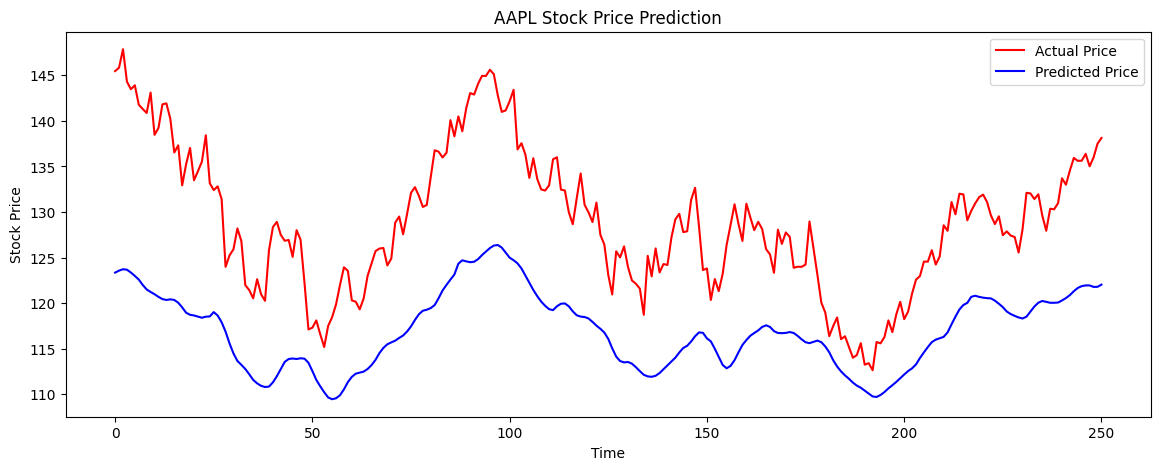

Processing MSFT.....
Epoch 1/100
24/24 [==============================] - 11s 151ms/step - loss: 0.0334 - val_loss: 0.0040
Epoch 2/100
24/24 [==============================] - 2s 83ms/step - loss: 0.0032 - val_loss: 0.0160
Epoch 3/100
24/24 [==============================] - 2s 88ms/step - loss: 0.0022 - val_loss: 0.0198
Epoch 4/100
24/24 [==============================] - 2s 69ms/step - loss: 0.0021 - val_loss: 0.0144
Epoch 5/100
24/24 [==============================] - 2s 77ms/step - loss: 0.0018 - val_loss: 0.0163
Epoch 6/100
24/24 [==============================] - 2s 74ms/step - loss: 0.0018 - val_loss: 0.0112
Epoch 7/100
24/24 [==============================] - 2s 79ms/step - loss: 0.0017 - val_loss: 0.0121
Epoch 8/100
24/24 [==============================] - 2s 90ms/step - loss: 0.0018 - val_loss: 0.0165
Epoch 9/100
24/24 [==============================] - 2s 77ms/step - loss: 0.0014 - val_loss: 0.0162
Epoch 10/100
24/24 [==============================] - 2s 77ms/step - loss: 0.

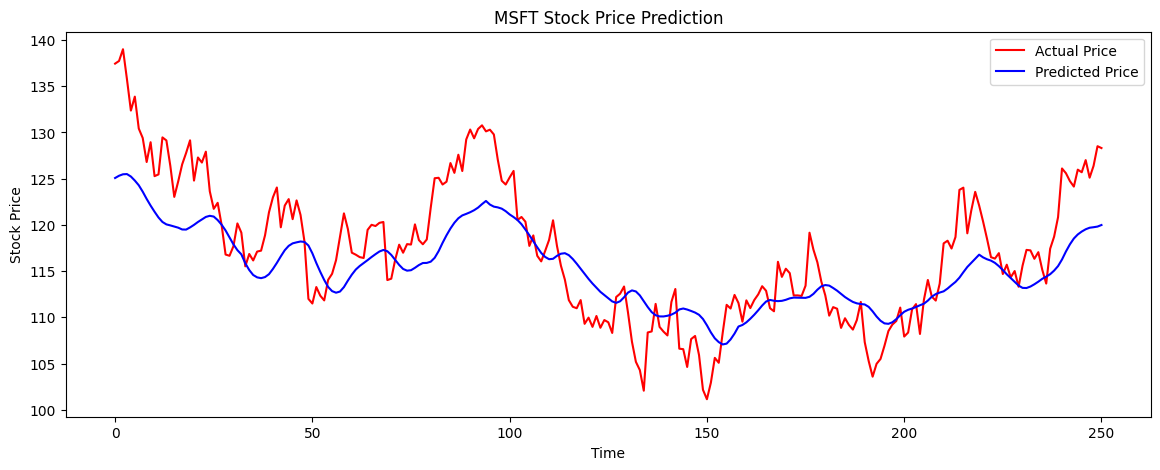

Processing META.....
Epoch 1/100
24/24 [==============================] - 4s 59ms/step - loss: 0.0285 - val_loss: 0.0285
Epoch 2/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0054 - val_loss: 0.0149
Epoch 3/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0036 - val_loss: 0.0095
Epoch 4/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0034 - val_loss: 0.0078
Epoch 5/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0030 - val_loss: 0.0063
Epoch 6/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0030 - val_loss: 0.0071
Epoch 7/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0029 - val_loss: 0.0055
Epoch 8/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0026 - val_loss: 0.0061
Epoch 9/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0030 - val_loss: 0.0073
Epoch 10/100
24/24 [==============================] - 1s 32ms/step - loss: 0.00

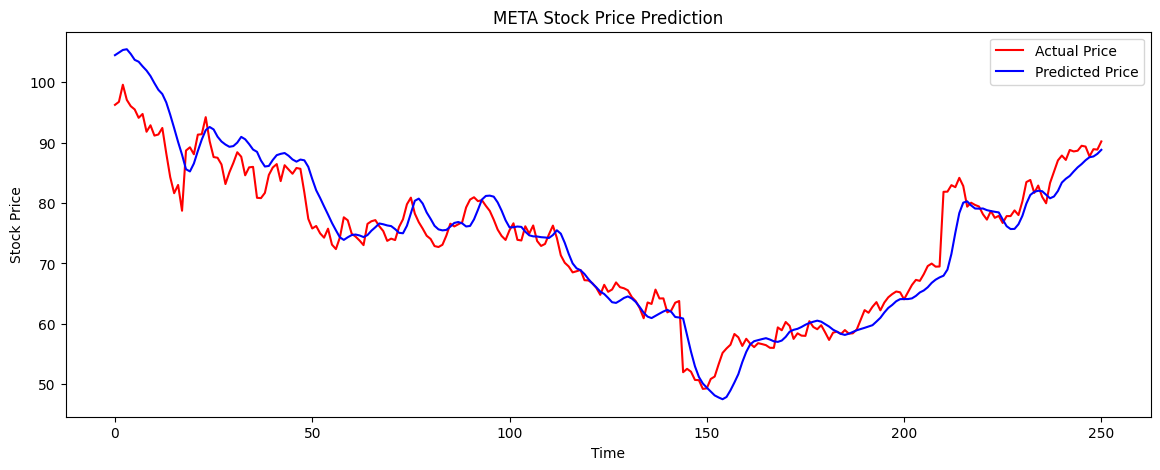

Processing GOOGL.....
Epoch 1/100
24/24 [==============================] - 4s 65ms/step - loss: 0.0083 - val_loss: 0.0153
Epoch 2/100
24/24 [==============================] - 1s 32ms/step - loss: 0.0020 - val_loss: 0.0068
Epoch 3/100
24/24 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 4/100
24/24 [==============================] - 1s 33ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 5/100
24/24 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 0.0095
Epoch 6/100
24/24 [==============================] - 1s 34ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 7/100
24/24 [==============================] - 1s 34ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 8/100
24/24 [==============================] - 1s 33ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 9/100
24/24 [==============================] - 1s 34ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 10/100
24/24 [==============================] - 1s 33ms/step - loss: 0.0

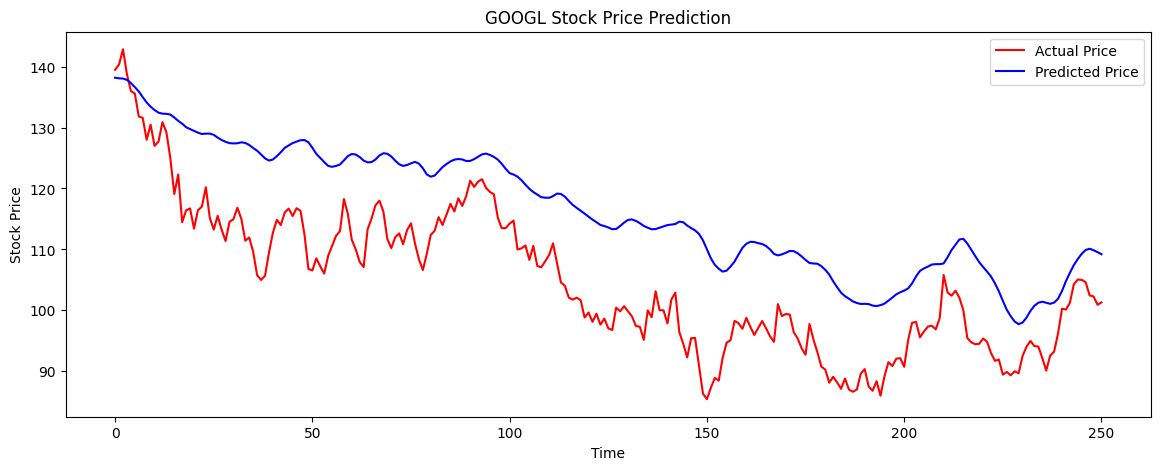

Shape of X_test for AMZN: (251, 60, 16)
Shape of y_test for AMZN: (251, 1)
Shape of X_test for AAPL: (251, 60, 16)
Shape of y_test for AAPL: (251, 1)
Shape of X_test for MSFT: (251, 60, 16)
Shape of y_test for MSFT: (251, 1)
Shape of X_test for META: (251, 60, 16)
Shape of y_test for META: (251, 1)
Shape of X_test for GOOGL: (251, 60, 16)
Shape of y_test for GOOGL: (251, 1)
AMZN X_train sample:
[[7.46513266e-03 3.80795937e-03 6.15006714e-03 6.89061003e-04
  2.97732534e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 8.83862701e-01
  6.93784912e-01 6.85482585e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.44177206e-03 0.00000000e+00
  2.14190385e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 8.67456226e-01
  6.94586697e-01 6.90516423e-01 0.00000000e+00 0.00000000e+00]
 [6.06091031e-03 0.00000000e+00 1.11318375e-02 0.00000000e+00
  2.51749966e-01 0.00000000e+00 0.00000000

In [15]:
def lstm_model(input_shape, units, dropout_rate, layers):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    return model

layers = 2
units = 64
dropout_rate = 0.3
epochs = 50
batch_size = 32

for ticker in tickers:
    print(f'Processing {ticker}.....')
    # Create and compile the model
    model = lstm_model((lookback, Split_Data[ticker]['X_train'].shape[2]), units, dropout_rate, layers)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    history = model.fit(Split_Data[ticker]['X_train'], Split_Data[ticker]['y_train'], epochs=100, batch_size=32,
                        validation_data=(Split_Data[ticker]['X_val'], Split_Data[ticker]['y_val']))
    # Make predictions
    predictions = model.predict(Split_Data[ticker]['X_test'])
    predictions = ScalerResponse.inverse_transform(predictions)
    # Calculate error metrics
    rmse = sqrt(mean_squared_error(Split_Data[ticker]['y_test'], predictions))
    mae = mean_absolute_error(Split_Data[ticker]['y_test'], predictions)

    print(f"{ticker} RMSE: {rmse}")
    print(f"{ticker} MAE: {mae}")

    # Plot actual vs predicted values
    plt.figure(figsize=(14, 5))
    plt.plot(ScalerResponse.inverse_transform(Split_Data[ticker]['y_test']), color='red', label='Actual Price')
    plt.plot(predictions, color='blue', label='Predicted Price')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show() 
for ticker in tickers:
    print(f"Shape of X_test for {ticker}: {Split_Data[ticker]['X_test'].shape}")
    print(f"Shape of y_test for {ticker}: {Split_Data[ticker]['y_test'].shape}")
for ticker in tickers:
    print(f"{ticker} X_train sample:\n{Split_Data[ticker]['X_train'][0]}\n")
    print(f"{ticker} y_train sample:\n{Split_Data[ticker]['y_train'][0]}\n")
    print(f"{ticker} X_test sample:\n{Split_Data[ticker]['X_test'][0]}\n")
    print(f"{ticker} y_test sample:\n{Split_Data[ticker]['y_test'][0]}\n")
model.summary()
from keras.utils import plot_model
 


In [16]:
# for ticker in tickers:
#     print(f"Shape of X_test for {ticker}: {Split_Data[ticker]['X_test'].shape}")
#     print(f"Shape of y_test for {ticker}: {Split_Data[ticker]['y_test'].shape}")


In [17]:
# for ticker in tickers:
#     print(f"{ticker} X_train sample:\n{Split_Data[ticker]['X_train'][0]}\n")
#     print(f"{ticker} y_train sample:\n{Split_Data[ticker]['y_train'][0]}\n")
#     print(f"{ticker} X_test sample:\n{Split_Data[ticker]['X_test'][0]}\n")
#     print(f"{ticker} y_test sample:\n{Split_Data[ticker]['y_test'][0]}\n")


In [18]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            13400     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_14 (Dropout)        (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

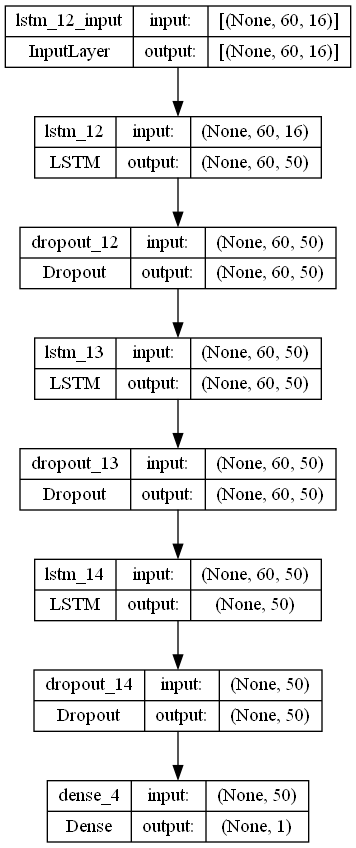

In [19]:
from keras.utils import plot_model

# Visualize the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)